In [0]:
!pip install tf-nightly-2.0-preview


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [12]:
len(time_valid), len(x_valid)

(461, 461)

In [16]:
results

array([70.48822 , 72.11706 , 72.65669 , 71.00434 , 68.43042 , 69.30246 ,
       68.968864, 71.36661 , 72.2463  , 73.43801 , 68.83704 , 71.84396 ,
       69.90779 , 74.1947  , 68.63785 , 72.81397 , 70.36605 , 67.565895,
       67.221794, 66.444496, 67.7682  , 69.83992 , 67.71593 , 68.61185 ,
       72.82773 , 75.65047 , 73.779   , 71.98242 , 70.26784 , 70.33446 ,
       66.33262 , 67.35373 , 64.2883  , 66.34093 , 69.03886 , 67.438126,
       72.92182 , 66.774765, 65.511665, 66.7788  , 69.57701 , 74.68965 ,
       70.64942 , 73.36156 , 70.11488 , 68.85486 , 71.46709 , 71.939995,
       66.43473 , 70.77082 , 73.19659 , 68.52271 , 71.33912 , 71.35284 ,
       70.37848 , 68.58142 , 67.61915 , 67.83135 , 71.12711 , 72.19176 ,
       70.23104 , 72.31534 , 64.84328 , 67.97651 , 63.32423 , 65.901276,
       64.87522 , 64.20576 , 68.5798  , 67.42073 , 70.25259 , 70.50531 ,
       71.29885 , 70.72827 , 67.096016, 70.34558 , 67.81802 , 65.49731 ,
       66.921005, 70.929924, 73.153946, 71.270004, 

In [11]:
series

array([ 52.48357 ,  49.35275 ,  53.314735, ...,  91.37325 ,  88.32383 ,
       122.30772 ], dtype=float32)

In [10]:
np.arange(4 * 365 + 1, dtype="float32")

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 1.458e+03, 1.459e+03,
       1.460e+03], dtype=float32)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

W1027 10:38:42.447604  2140 deprecation.py:323] From C:\Users\hero144\.conda\envs\py36\lib\site-packages\tensorflow\python\data\util\random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
8/8 [==============================] - 1s 152ms/step - loss: 195.6165 - mae: 196.0721
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 194.8099 - mae: 195.2815
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 193.5298 - mae: 194.0093
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 191.9202 - mae: 192.4067
Epoch 5/100
8/8 [==============================] - 0s 14ms/step - loss: 190.0269 - mae: 190.5205
Epoch 6/100
8/8 [==============================] - 0s 14ms/step - loss: 187.8482 - mae: 188.3494
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 185.3580 - mae: 185.8679
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 182.5147 - mae: 183.0343
Epoch 9/100
8/8 [==============================] - 0s 14ms/step - loss: 179.2628 - mae: 179.7937: 0s - loss: 179.3696 - mae: 179.869
Epoch 10/100
8/8 [==============================] - 0s 14ms/step - loss: 175.5317 - mae: 1

8/8 [==============================] - 0s 15ms/step - loss: 14.2511 - mae: 14.1577
Epoch 86/100
8/8 [==============================] - 0s 14ms/step - loss: 27.9889 - mae: 29.0419
Epoch 87/100
8/8 [==============================] - 0s 14ms/step - loss: 18.2489 - mae: 18.6936
Epoch 88/100
8/8 [==============================] - 0s 15ms/step - loss: 22.8518 - mae: 22.5142
Epoch 89/100
8/8 [==============================] - 0s 14ms/step - loss: 37.1058 - mae: 37.4879
Epoch 90/100
8/8 [==============================] - ETA: 0s - loss: 30.6868 - mae: 31.185 - 0s 14ms/step - loss: 31.2498 - mae: 31.5858
Epoch 91/100
8/8 [==============================] - 0s 15ms/step - loss: 32.1023 - mae: 32.6731
Epoch 92/100
8/8 [==============================] - 0s 14ms/step - loss: 33.4631 - mae: 34.1413
Epoch 93/100
8/8 [==============================] - 0s 15ms/step - loss: 32.0718 - mae: 33.1710
Epoch 94/100
8/8 [==============================] - 0s 14ms/step - loss: 34.1937 - mae: 35.4607
Epoch 95/100


[1e-08, 0.0001, 0, 30]

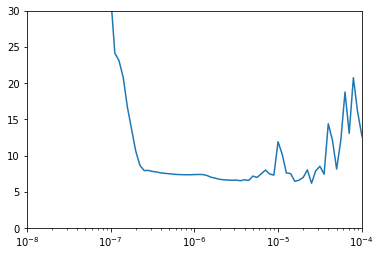

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 1s 140ms/step - loss: 80.8704 - mae: 83.5783
Epoch 2/400
8/8 [==============================] - 0s 14ms/step - loss: 23.3277 - mae: 24.1570
Epoch 3/400
8/8 [==============================] - 0s 13ms/step - loss: 17.8615 - mae: 18.4302
Epoch 4/400
8/8 [==============================] - 0s 14ms/step - loss: 11.9518 - mae: 12.5090
Epoch 5/400
8/8 [==============================] - 0s 15ms/step - loss: 10.2061 - mae: 10.3494
Epoch 6/400
8/8 [==============================] - 0s 14ms/step - loss: 14.0039 - mae: 14.3483
Epoch 7/400
8/8 [==============================] - 0s 14ms/step - loss: 12.9693 - mae: 13.4709
Epoch 8/400
8/8 [==============================] - 0s 14ms/step - loss: 9.7125 - mae: 10.3025
Epoch 9/400
8/8 [==============================] - 0s 15ms/step - loss: 9.0673 - mae: 9.6734
Epoch 10/400
8/8 [==============================] - 0s 14ms/step - loss: 9.8556 - mae: 10.1269
Epoch 11/400
8/8 [==============================] - 

8/8 [==============================] - 0s 14ms/step - loss: 5.4920 - mae: 5.9833
Epoch 88/400
8/8 [==============================] - 0s 14ms/step - loss: 5.6873 - mae: 6.1481
Epoch 89/400
8/8 [==============================] - 0s 15ms/step - loss: 4.9584 - mae: 5.4667
Epoch 90/400
8/8 [==============================] - 0s 14ms/step - loss: 4.9258 - mae: 5.4371
Epoch 91/400
8/8 [==============================] - 0s 13ms/step - loss: 4.9554 - mae: 5.4283
Epoch 92/400
8/8 [==============================] - 0s 14ms/step - loss: 5.2924 - mae: 5.7553
Epoch 93/400
8/8 [==============================] - 0s 15ms/step - loss: 5.2713 - mae: 5.7491
Epoch 94/400
8/8 [==============================] - 0s 15ms/step - loss: 4.8075 - mae: 5.3029
Epoch 95/400
8/8 [==============================] - 0s 14ms/step - loss: 5.1786 - mae: 5.6409
Epoch 96/400
8/8 [==============================] - 0s 14ms/step - loss: 5.3733 - mae: 5.8112
Epoch 97/400
8/8 [==============================] - 0s 14ms/step - loss: 

8/8 [==============================] - 0s 15ms/step - loss: 4.7256 - mae: 5.2183
Epoch 174/400
8/8 [==============================] - 0s 16ms/step - loss: 4.6832 - mae: 5.1814
Epoch 175/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6694 - mae: 5.1617
Epoch 176/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6531 - mae: 5.1478
Epoch 177/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6821 - mae: 5.1750
Epoch 178/400
8/8 [==============================] - 0s 17ms/step - loss: 4.6758 - mae: 5.1701
Epoch 179/400
8/8 [==============================] - 0s 17ms/step - loss: 4.7856 - mae: 5.2641
Epoch 180/400
8/8 [==============================] - 0s 16ms/step - loss: 4.5949 - mae: 5.0911
Epoch 181/400
8/8 [==============================] - 0s 16ms/step - loss: 4.6705 - mae: 5.1689
Epoch 182/400
8/8 [==============================] - 0s 16ms/step - loss: 4.8133 - mae: 5.2931
Epoch 183/400
8/8 [==============================] - 0s 16ms/ste

8/8 [==============================] - 0s 15ms/step - loss: 4.6553 - mae: 5.1389
Epoch 260/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6442 - mae: 5.1235
Epoch 261/400
8/8 [==============================] - 0s 15ms/step - loss: 4.5977 - mae: 5.0822
Epoch 262/400
8/8 [==============================] - 0s 15ms/step - loss: 4.5432 - mae: 5.0493
Epoch 263/400
8/8 [==============================] - 0s 15ms/step - loss: 4.4125 - mae: 4.9052
Epoch 264/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6573 - mae: 5.1545
Epoch 265/400
8/8 [==============================] - 0s 16ms/step - loss: 4.6287 - mae: 5.0980
Epoch 266/400
8/8 [==============================] - 0s 15ms/step - loss: 4.5349 - mae: 5.0343
Epoch 267/400
8/8 [==============================] - 0s 15ms/step - loss: 4.5465 - mae: 5.0277
Epoch 268/400
8/8 [==============================] - 0s 15ms/step - loss: 4.7617 - mae: 5.2390
Epoch 269/400
8/8 [==============================] - 0s 15ms/ste

8/8 [==============================] - 0s 15ms/step - loss: 4.5103 - mae: 5.0001
Epoch 346/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6613 - mae: 5.1302
Epoch 347/400
8/8 [==============================] - 0s 15ms/step - loss: 4.9013 - mae: 5.3598
Epoch 348/400
8/8 [==============================] - 0s 15ms/step - loss: 4.3688 - mae: 4.8536
Epoch 349/400
8/8 [==============================] - 0s 15ms/step - loss: 4.6542 - mae: 5.1669
Epoch 350/400
8/8 [==============================] - 0s 15ms/step - loss: 5.1079 - mae: 5.5657
Epoch 351/400
8/8 [==============================] - 0s 15ms/step - loss: 4.2819 - mae: 4.7738
Epoch 352/400
8/8 [==============================] - 0s 15ms/step - loss: 4.4269 - mae: 4.8669
Epoch 353/400
8/8 [==============================] - 0s 15ms/step - loss: 4.3034 - mae: 4.8018
Epoch 354/400
8/8 [==============================] - 0s 15ms/step - loss: 4.2041 - mae: 4.6823
Epoch 355/400
8/8 [==============================] - 0s 15ms/ste

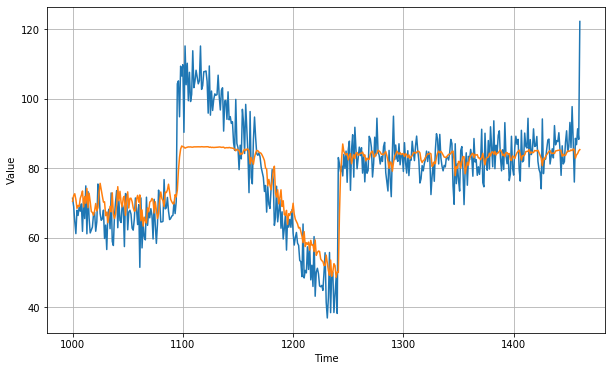

In [7]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

In [0]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()